In [1]:
# https://developers.tokenmetrics.com/docs/3-backtesting-and-analysis

In [1]:
import pandas as pd
import backtrader as bt
import numpy as np
import pyfolio as pf
import matplotlib.pyplot as plt
import yfinance as yf

import csv
import pytz

from pandas_datareader import data as pdr
from utils.common import backtrader_plot
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
with pd.HDFStore('./large_files/data2.h5', mode='r') as store:
    df_ = store.get('data/data_imputed_20240226')
df_.info(verbose=3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2522881 entries, 525 to 138563
Data columns (total 10 columns):
 #   Column    Dtype                           
---  ------    -----                           
 0   date      object                          
 1   time      object                          
 2   open      float64                         
 3   high      float64                         
 4   low       float64                         
 5   close     float64                         
 6   volume    int64                           
 7   datetime  datetime64[ns, America/New_York]
 8   day       object                          
 9   month     int64                           
dtypes: datetime64[ns, America/New_York](1), float64(4), int64(2), object(3)
memory usage: 211.7+ MB


In [3]:
df = df_.set_index('datetime', drop=False)
df = df.loc[df.index.year.isin([2021, 2022])]
df = df.loc[df.index.day_of_week == 2]

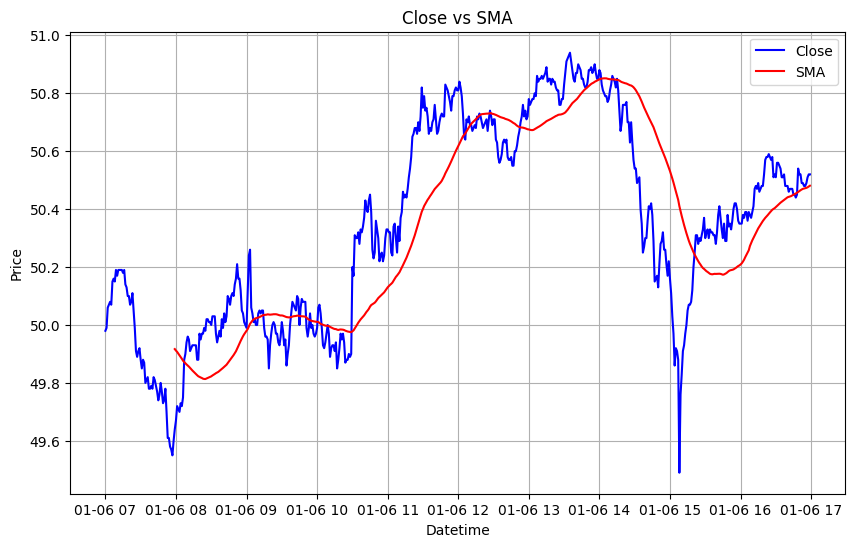

In [4]:
for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()

    df_day['sma'] = df_day['close'].rolling(60).mean()
    df_day['datetime'] = pd.to_datetime(df_day['datetime'])

    # Plotting
    plt.figure(figsize=(10, 6))  # Adjust size as needed
    plt.plot(df_day['datetime'], df_day['close'], color='blue', label='Close')  # Plot close with blue color
    plt.plot(df_day['datetime'], df_day['sma'], color='red', label='SMA')  # Plot sma with red color
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.title('Close vs SMA')
    plt.legend()  # Show legend
    plt.grid(True)  # Add grid
    plt.show()
    break

# Mean Reversion Strategy
1. Enter when current price is less than -1.0 std relative to sma.
1. Exit when current price is more than 1.0 std relative to sma  

*If a simple MA based strategy works decently, it suggests that trend trading is suitable*

In [17]:
class MeanReversionStrategy(bt.Strategy):
    params = (
        ('period', 15),  # Period for the moving average
        ('devfactor', 1.0),  # Factor for z-score threshold
        ('csv_writer', None)
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.sma = bt.indicators.SimpleMovingAverage(self.dataclose, period=self.params.period)
        self.std = bt.indicators.StandardDeviation(self.dataclose, period=self.params.period)
        self.z_score = (self.dataclose - self.sma) / self.std

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        shares = self.position.size
        print('%s, %s, Cash: %.2f, Portfolio Value: %.2f, Shares Owned: %d' % (dt.isoformat(), txt, cash, value, shares))

    def next(self):
        if self.z_score[0] > 0 and self.position:
            self.log('Short at %.2f' % self.dataclose[0])
            self.sell()

        elif self.z_score[0] < -self.params.devfactor:
            self.log('Long at %.2f' % self.dataclose[0])
            self.buy()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('Buy executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Buy', order.executed.price])
            elif order.issell():
                self.log('Sell executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', order.executed.price])

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def stop(self):
        if self.position:
            self.log('Closing position')
            self.close()
            if self.params.csv_writer is not None:
                self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', self.dataclose[0]])

In [18]:
df_result = []

csv_file = open('outputs/mean_reversion00.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Date', 'Action', 'Price'])

capital = 100 * 1e3
for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    if capital < 50000:
        print('Early stopping')
        break

    if df_day.shape[0] == 0:
        continue
    
    df_day = df_day.copy()
    df_day = df_day[(df_day.index.hour >= 10) & (df_day.index.hour < 12)]
    data = bt.feeds.PandasData(dataname=df_day)
    
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(capital)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
    cerebro.adddata(data)
    cerebro.addstrategy(MeanReversionStrategy, devfactor=1.0, csv_writer=csv_writer)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    bt_results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('\n\n')

    strat = bt_results[0]

    pnl = cerebro.broker.getvalue() - cerebro.broker.startingcash

    df_result.append({
        'datetime': day,
        'portfolio': cerebro.broker.getvalue(),
        'pnl': pnl,
        # 'sharpe_ratio': sharpe_ratio
    })
    capital = cerebro.broker.getvalue()
csv_file.close()
df_result = pd.DataFrame(df_result)

Starting Portfolio Value: 100000.00
2021-01-06T15:15:00, Long at 49.91, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:16:00, Buy executed at 49.91, Cash: 0.00, Portfolio Value: 100060.11, Shares Owned: 2003
2021-01-06T15:17:00, Long at 49.85, Cash: 0.00, Portfolio Value: 99879.78, Shares Owned: 2003
2021-01-06T15:18:00, Order Canceled/Margin/Rejected, Cash: 0.00, Portfolio Value: 99939.89, Shares Owned: 2003
2021-01-06T15:18:00, Long at 49.88, Cash: 0.00, Portfolio Value: 99939.89, Shares Owned: 2003
2021-01-06T15:19:00, Order Canceled/Margin/Rejected, Cash: 0.00, Portfolio Value: 100020.04, Shares Owned: 2003
2021-01-06T15:20:00, Short at 49.97, Cash: 0.00, Portfolio Value: 100120.22, Shares Owned: 2003
2021-01-06T15:21:00, Sell executed at 49.97, Cash: 100120.22, Portfolio Value: 100120.22, Shares Owned: 0
2021-01-06T15:21:00, OPERATION PROFIT, GROSS 120.22, NET 120.22, Cash: 100120.22, Portfolio Value: 100120.22, Shares Owned: 0
2021-01-06T15:24:00, Long

<Axes: xlabel='datetime'>

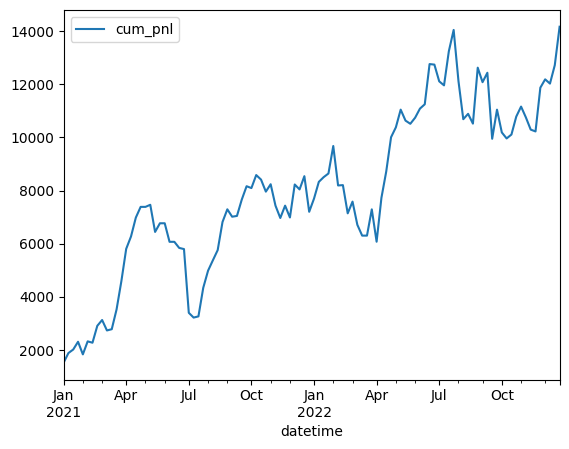

In [19]:
df_trades = pd.read_csv('./outputs/mean_reversion00.csv')
df_trades['Date'] = pd.to_datetime(df_trades['Date'])
timezone = pytz.timezone('Etc/GMT+6')
sharpes = []
for day, df_day in df_trades.groupby(pd.Grouper(key='Date', freq='D')):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()
    df_buy = df_day[df_day['Action'] == 'Buy']
    df_sell = df_day[df_day['Action'] == 'Sell']
    returns = df_sell['Price'].to_numpy() - df_buy['Price'].to_numpy()

    n_winning_trades = (returns > 0).astype(int).sum()
    n_losing_trades = len(returns) - n_winning_trades
    
    sharpe_ratio = np.mean(returns) / max(0.001, np.std(returns))
    sharpes.append({
        'datetime': day.tz_localize('US/Eastern'), 
        'n_trades': len(returns),
        'n_winning_trades': n_winning_trades,
        'n_losing_trades': n_losing_trades,
        'sharpe_ratio': sharpe_ratio,
    })

sharpes = pd.DataFrame(sharpes)
df_result = pd.merge(df_result, sharpes, how='left', on='datetime')
df_result['cum_pnl'] = df_result['pnl'].cumsum()
df_result.plot(x='datetime', y='cum_pnl')

# July losing money?

In [8]:
print(
    f'Average: {df_result["pnl"].mean():.2f}  Sharpe Ratio: {df_result["sharpe_ratio"].mean():.2f}\n' \
    f'Wins: {(df_result["pnl"] > 0).sum()}  Avg: {df_result.loc[df_result["pnl"] > 0, "pnl"].mean():.2f}\n' \
    f'Losses: {(df_result["pnl"] < 0).sum()}  Avg: {df_result.loc[df_result["pnl"] < 0, "pnl"].mean():.2f}\n'
)

# plt.rcParams['figure.figsize'] = [15, 12]
# plt.rcParams.update({'font.size': 12})

Average: 136.16  Sharpe Ratio: 2.15
Wins: 63  Avg: 621.60
Losses: 41  Avg: -609.76



2024 January / February

In [10]:
df2 = df_.set_index('datetime', drop=False)
df2 = df2.loc[df2.index.year.isin([2024])]
df2 = df2.loc[df2.index.day_of_week == 2]

df_result = []

csv_file = open('outputs/mean_reversion01.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Date', 'Action', 'Price'])

capital = 100 * 1e3
for day, df_day in df2.groupby(pd.Grouper(key='datetime', freq='D')):
    if capital < 50000:
        print('Early stopping')
        break

    if df_day.shape[0] == 0:
        continue
    
    df_day = df_day.copy()
    df_day = df_day[(df_day.index.hour >= 10) & (df_day.index.hour < 12)]
    data = bt.feeds.PandasData(dataname=df_day)
    
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(capital)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
    cerebro.adddata(data)
    cerebro.addstrategy(MeanReversionStrategy, devfactor=1.0, csv_writer=csv_writer)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    bt_results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('\n\n')

    strat = bt_results[0]

    pnl = cerebro.broker.getvalue() - cerebro.broker.startingcash

    df_result.append({
        'datetime': day,
        'portfolio': cerebro.broker.getvalue(),
        'pnl': pnl,
        # 'sharpe_ratio': sharpe_ratio
    })
    capital = cerebro.broker.getvalue()
csv_file.close()
df_result = pd.DataFrame(df_result)

Starting Portfolio Value: 100000.00
2024-01-03T15:15:00, Long at 72.37, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2024-01-03T15:16:00, Buy executed at 72.37, Cash: 0.00, Portfolio Value: 99903.28, Shares Owned: 1381
2024-01-03T15:16:00, Long at 72.30, Cash: 0.00, Portfolio Value: 99903.28, Shares Owned: 1381
2024-01-03T15:17:00, Order Canceled/Margin/Rejected, Cash: 0.00, Portfolio Value: 99958.54, Shares Owned: 1381
2024-01-03T15:17:00, Long at 72.34, Cash: 0.00, Portfolio Value: 99958.54, Shares Owned: 1381
2024-01-03T15:18:00, Order Canceled/Margin/Rejected, Cash: 0.00, Portfolio Value: 99848.00, Shares Owned: 1381
2024-01-03T15:18:00, Long at 72.26, Cash: 0.00, Portfolio Value: 99848.00, Shares Owned: 1381
2024-01-03T15:19:00, Order Canceled/Margin/Rejected, Cash: 0.00, Portfolio Value: 99875.63, Shares Owned: 1381
2024-01-03T15:19:00, Long at 72.28, Cash: 0.00, Portfolio Value: 99875.63, Shares Owned: 1381
2024-01-03T15:20:00, Order Canceled/Margin/Rejected, Cas

<Axes: title={'center': '584.2836494093062'}, xlabel='datetime'>

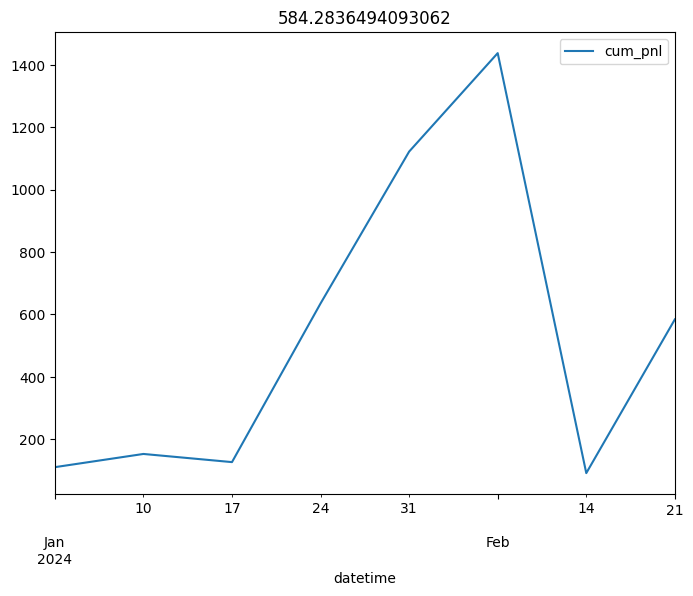

In [11]:
df_trades = pd.read_csv('./outputs/mean_reversion01.csv')
df_trades['Date'] = pd.to_datetime(df_trades['Date'])
timezone = pytz.timezone('Etc/GMT+6')
sharpes = []
for day, df_day in df_trades.groupby(pd.Grouper(key='Date', freq='D')):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()
    df_buy = df_day[df_day['Action'] == 'Buy']
    df_sell = df_day[df_day['Action'] == 'Sell']
    returns = df_sell['Price'].to_numpy() - df_buy['Price'].to_numpy()

    n_winning_trades = (returns > 0).astype(int).sum()
    n_losing_trades = len(returns) - n_winning_trades
    
    sharpe_ratio = np.mean(returns) / max(0.001, np.std(returns))
    sharpes.append({
        'datetime': day.tz_localize('US/Eastern'), 
        'n_trades': len(returns),
        'n_winning_trades': n_winning_trades,
        'n_losing_trades': n_losing_trades,
        'sharpe_ratio': sharpe_ratio,
    })

sharpes = pd.DataFrame(sharpes)
df_result = pd.merge(df_result, sharpes, how='left', on='datetime')
df_result['cum_pnl'] = df_result['pnl'].cumsum()
df_result.plot(x='datetime', y='cum_pnl', title=df_result['cum_pnl'].tolist()[-1], figsize=(8, 6))

In [12]:
print(
    f'Average: {df_result["pnl"].mean():.2f}  Sharpe Ratio: {df_result["sharpe_ratio"].mean():.2f}\n' \
    f'Wins: {(df_result["pnl"] > 0).sum()}  Avg: {df_result.loc[df_result["pnl"] > 0, "pnl"].mean():.2f}\n' \
    f'Losses: {(df_result["pnl"] < 0).sum()}  Avg: {df_result.loc[df_result["pnl"] < 0, "pnl"].mean():.2f}\n'
)

Average: 73.04  Sharpe Ratio: 0.90
Wins: 6  Avg: 326.23
Losses: 2  Avg: -686.55



# SMA Crossover Strategy

In [13]:
class SMACrossoverStrategy(bt.Strategy):
    params = (
        ('sma_period_short', 20),
        ('sma_period_long', 50),
        ('csv_writer', None)
    )

    def __init__(self):
        self.sma_short = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period_short)
        self.sma_long = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period_long)
        self.crossover = bt.indicators.CrossOver(self.sma_short, self.sma_long)
        self.dataclose = self.datas[0].close

    def next(self):
        if self.position.size == 0:  # If not in the market
            if self.crossover > 0:   # If short SMA crosses above long SMA
                self.log('Long at %.2f' % self.dataclose[0])
                self.buy()

        elif self.position.size > 0:  # If in a long position
            if self.crossover < 0:    # If short SMA crosses below long SMA
                self.log('Short at %.2f' % self.dataclose[0])
                self.sell()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('Buy executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Buy', order.executed.price])
            elif order.issell():
                self.log('Sell executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', order.executed.price])

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def stop(self):
        if self.position:
            self.log('Closing position')
            self.close()
            if self.params.csv_writer is not None:
                self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', self.dataclose[0]])

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        shares = self.position.size
        print('%s, %s, Cash: %.2f, Portfolio Value: %.2f, Shares Owned: %d' % (dt.isoformat(), txt, cash, value, shares))

In [14]:
df_result = []

csv_file = open('outputs/smaxover00.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Date', 'Action', 'Price'])

capital = 100 * 1e3
for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    if capital < 50000:
        print('Early stopping')
        break

    if df_day.shape[0] == 0:
        continue
    
    df_day = df_day.copy()
    df_day = df_day[(df_day.index.hour >= 9) & (df_day.index.hour < 12)]
    data = bt.feeds.PandasData(dataname=df_day)
    
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(capital)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
    cerebro.adddata(data)
    cerebro.addstrategy(SMACrossoverStrategy, sma_period_short=20, sma_period_long=50, csv_writer=csv_writer)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    bt_results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('\n\n')

    strat = bt_results[0]

    pnl = cerebro.broker.getvalue() - cerebro.broker.startingcash

    df_result.append({
        'datetime': day,
        'portfolio': cerebro.broker.getvalue(),
        'pnl': pnl
    })
    capital = cerebro.broker.getvalue()
csv_file.close()
df_result = pd.DataFrame(df_result)

Starting Portfolio Value: 100000.00
2021-01-06T15:34:00, Long at 50.30, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:35:00, Buy executed at 50.30, Cash: 0.00, Portfolio Value: 100039.76, Shares Owned: 1988
2021-01-06T16:59:00, Closing position, Cash: 0.00, Portfolio Value: 101013.92, Shares Owned: 1988
Final Portfolio Value: 101013.92



Starting Portfolio Value: 101013.92
2021-01-13T15:07:00, Long at 52.97, Cash: 101013.92, Portfolio Value: 101013.92, Shares Owned: 0
2021-01-13T15:08:00, Buy executed at 52.96, Cash: 19.07, Portfolio Value: 101032.99, Shares Owned: 1907
2021-01-13T16:14:00, Short at 53.06, Cash: 19.07, Portfolio Value: 101204.62, Shares Owned: 1907
2021-01-13T16:15:00, Sell executed at 53.05, Cash: 101185.55, Portfolio Value: 101185.55, Shares Owned: 0
2021-01-13T16:15:00, OPERATION PROFIT, GROSS 171.63, NET 171.63, Cash: 101185.55, Portfolio Value: 101185.55, Shares Owned: 0
Final Portfolio Value: 101185.55



Starting Portfolio Value: 10

<Axes: title={'center': '5620.466068468639'}, xlabel='datetime'>

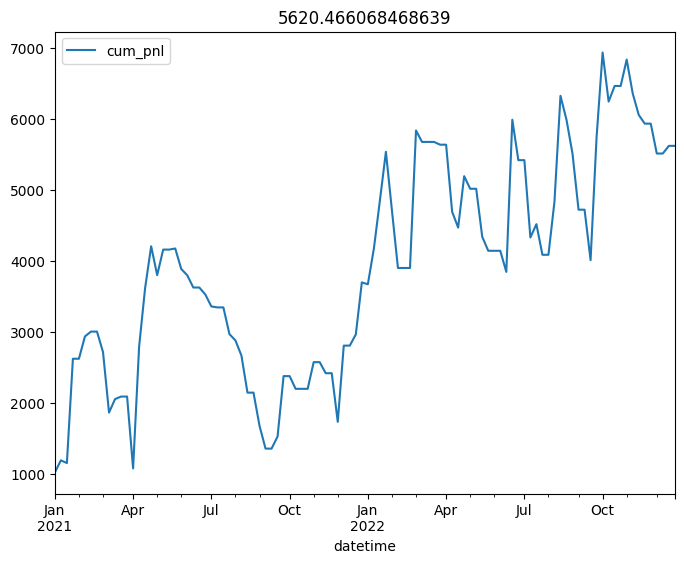

In [15]:
df_trades = pd.read_csv('./outputs/smaxover00.csv')
df_trades['Date'] = pd.to_datetime(df_trades['Date'])
timezone = pytz.timezone('Etc/GMT+6')
sharpes = []
for day, df_day in df_trades.groupby(pd.Grouper(key='Date', freq='D')):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()
    df_buy = df_day[df_day['Action'] == 'Buy']
    df_sell = df_day[df_day['Action'] == 'Sell']
    returns = df_sell['Price'].to_numpy() - df_buy['Price'].to_numpy()

    n_winning_trades = (returns > 0).astype(int).sum()
    n_losing_trades = len(returns) - n_winning_trades
    
    sharpe_ratio = np.mean(returns) / max(0.001, np.std(returns))
    sharpes.append({
        'datetime': day.tz_localize('US/Eastern'), 
        'n_trades': len(returns),
        'n_winning_trades': n_winning_trades,
        'n_losing_trades': n_losing_trades,
        'sharpe_ratio': sharpe_ratio,
    })

sharpes = pd.DataFrame(sharpes)
df_result = pd.merge(df_result, sharpes, how='left', on='datetime')
df_result['cum_pnl'] = df_result['pnl'].cumsum()
df_result.plot(x='datetime', y='cum_pnl', title=df_result['cum_pnl'].tolist()[-1], figsize=(8, 6))

In [16]:
print(
    f'Average: {df_result["pnl"].mean():.2f}  Sharpe Ratio: {df_result["sharpe_ratio"].mean():.2f}\n' \
    f'Wins: {(df_result["pnl"] > 0).sum()}  Avg: {df_result.loc[df_result["pnl"] > 0, "pnl"].mean():.2f}\n' \
    f'Losses: {(df_result["pnl"] < 0).sum()}  Avg: {df_result.loc[df_result["pnl"] < 0, "pnl"].mean():.2f}\n'
)

Average: 54.04  Sharpe Ratio: 20.87
Wins: 32  Avg: 714.80
Losses: 43  Avg: -401.23



# SMA Breakout Strategy
1. Long when price breakouts of SMA for certain percentage

In [17]:
class SMABreakoutStrategy(bt.Strategy):
    params = (
        ('sma_period', 50),
        ('breakout_buffer', 0.01),  # Buffer percentage for breakout
        ('csv_writer', None),
    )

    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period)
        self.breakout_buffer = self.params.breakout_buffer
        self.dataclose = self.datas[0].close

    def next(self):
        if self.position.size == 0:  # If not in the market
            if self.data.close[0] > self.sma[0] * (1 + self.breakout_buffer):  # If price breaks above SMA
                self.log('Long at %.2f' % self.dataclose[0])
                self.buy()

        elif self.position.size > 0:  # If in a long position
            if self.data.close[0] < self.sma[0]:  # If price crosses below SMA
                self.log('Short at %.2f' % self.dataclose[0])
                self.sell()
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('Buy executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Buy', order.executed.price])
            elif order.issell():
                self.log('Sell executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', order.executed.price])

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            if order.status == order.Canceled:
                self.log('Order Canceled')
            elif order.status == order.Margin:
                self.log('Order Margin')
            else:
                self.log('Order Rejected')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def stop(self):
        if self.position:
            self.log('Closing position')
            self.close()
            if self.params.csv_writer is not None:
                self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', self.dataclose[0]])

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        shares = self.position.size
        print('%s, %s, Cash: %.2f, Portfolio Value: %.2f, Shares Owned: %d' % (dt.isoformat(), txt, cash, value, shares))

In [18]:
df_result = []

csv_file = open('outputs/smabreakout00.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Date', 'Action', 'Price'])

capital = 100 * 1e3
for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    if capital < 50000:
        print('Early stopping')
        break
    if df_day.shape[0] == 0:
        continue
    
    df_day = df_day.copy()
    df_day = df_day[(df_day.index.hour >= 9) & (df_day.index.hour < 12)]
    data = bt.feeds.PandasData(dataname=df_day)
    
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(capital)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
    cerebro.adddata(data)
    cerebro.addstrategy(SMABreakoutStrategy, sma_period=15, breakout_buffer=0.005, csv_writer=csv_writer)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    bt_results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('\n\n')

    strat = bt_results[0]

    pnl = cerebro.broker.getvalue() - cerebro.broker.startingcash

    df_result.append({
        'datetime': day,
        'portfolio': cerebro.broker.getvalue(),
        'pnl': pnl
    })
    capital = cerebro.broker.getvalue()
csv_file.close()
df_result = pd.DataFrame(df_result)

Starting Portfolio Value: 100000.00
2021-01-06T15:30:00, Long at 50.20, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:31:00, Order Margin, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:32:00, Long at 50.31, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:33:00, Order Margin, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:33:00, Long at 50.30, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:34:00, Order Margin, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:34:00, Long at 50.30, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:35:00, Buy executed at 50.30, Cash: 0.00, Portfolio Value: 100039.76, Shares Owned: 1988
2021-01-06T15:47:00, Short at 50.26, Cash: 0.00, Portfolio Value: 99920.48, Shares Owned: 1988
2021-01-06T15:48:00, Sell executed at 50.25, Cash: 99900.60, Portfolio Value: 99900.60, Sh

<Axes: title={'center': '-343.8491144982545'}, xlabel='datetime'>

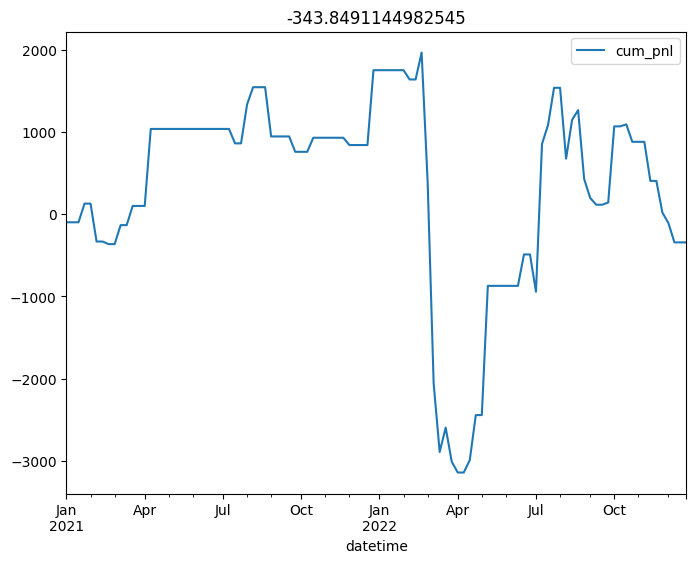

In [19]:
df_trades = pd.read_csv('./outputs/smabreakout00.csv')
df_trades['Date'] = pd.to_datetime(df_trades['Date'])
timezone = pytz.timezone('Etc/GMT+6')
sharpes = []
for day, df_day in df_trades.groupby(pd.Grouper(key='Date', freq='D')):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()
    df_buy = df_day[df_day['Action'] == 'Buy']
    df_sell = df_day[df_day['Action'] == 'Sell']
    returns = df_sell['Price'].to_numpy() - df_buy['Price'].to_numpy()

    n_winning_trades = (returns > 0).astype(int).sum()
    n_losing_trades = len(returns) - n_winning_trades
    
    sharpe_ratio = np.mean(returns) / max(0.001, np.std(returns))
    sharpes.append({
        'datetime': day.tz_localize('US/Eastern'), 
        'n_trades': len(returns),
        'n_winning_trades': n_winning_trades,
        'n_losing_trades': n_losing_trades,
        'sharpe_ratio': sharpe_ratio,
    })

sharpes = pd.DataFrame(sharpes)
df_result = pd.merge(df_result, sharpes, how='left', on='datetime')
df_result['cum_pnl'] = df_result['pnl'].cumsum()
df_result.plot(x='datetime', y='cum_pnl', title=df_result['cum_pnl'].tolist()[-1], figsize=(8, 6))

In [20]:
print(
    f'Average: {df_result["pnl"].mean():.2f}  Sharpe Ratio: {df_result["sharpe_ratio"].mean():.2f}\n' \
    f'Wins: {(df_result["pnl"] > 0).sum()}  Avg: {df_result.loc[df_result["pnl"] > 0, "pnl"].mean():.2f}\n' \
    f'Losses: {(df_result["pnl"] < 0).sum()}  Avg: {df_result.loc[df_result["pnl"] < 0, "pnl"].mean():.2f}\n'
)

# Sharpe ratio is high due to the minimal amount of trades per day

Average: -3.31  Sharpe Ratio: 44.85
Wins: 22  Avg: 486.82
Losses: 23  Avg: -480.60



# Mean Reversion with Volume Oscillator

In [21]:
class MeanReversionVolumeOscillatorStrategy(bt.Strategy):
    params = (
        ('period', 15),  # Period for the moving average
        ('devfactor', 1.0),  # Factor for z-score threshold
        ('vo_period_fast', 10),  # Fast period for Volume Oscillator
        ('vo_period_slow', 30),  # Slow period for Volume Oscillator
        ('vo_threshold', 0.0),  # Threshold for Volume Oscillator crossover
        ('csv_writer', None)
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)
        self.std = bt.indicators.StandardDeviation(self.datas[0], period=self.params.period)
        self.z_score = (self.dataclose - self.sma) / self.std

        # Volume Oscillator
        self.vo_fast = bt.indicators.SimpleMovingAverage(self.datas[0].volume, period=self.params.vo_period_fast)
        self.vo_slow = bt.indicators.SimpleMovingAverage(self.datas[0].volume, period=self.params.vo_period_slow)
        self.vo = self.vo_fast - self.vo_slow

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        shares = self.position.size
        print('%s, %s, Cash: %.2f, Portfolio Value: %.2f, Shares Owned: %d' % (dt.isoformat(), txt, cash, value, shares))

    def next(self):
        past_close = []
        for i in range(1, self.params.period):
            past_close.append(self.datas[0].close[-i])

        if self.z_score[0] > 0 and self.position:
            self.log('Short at %.2f' % self.dataclose[0])
            self.sell()

        elif self.z_score[0] < -self.params.devfactor and self.vo[0] > self.params.vo_threshold:
            self.log('Long at %.2f' % self.dataclose[0])
            self.buy()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('Buy executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Buy', order.executed.price])
            elif order.issell():
                self.log('Sell executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', order.executed.price])

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def stop(self):
        if self.position:
            self.log('Closing position')
            self.close()
            if self.params.csv_writer is not None:
                self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', self.dataclose[0]])


In [22]:
df_result = []

csv_file = open('outputs/meanrevvol00.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Date', 'Action', 'Price'])

capital = 100 * 1e3
for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    if capital < 50000:
        print('Early stopping')
        break
    if df_day.shape[0] == 0:
        continue
    
    df_day = df_day.copy()
    df_day = df_day[(df_day.index.hour >= 9) & (df_day.index.hour < 12)]
    data = bt.feeds.PandasData(dataname=df_day)
    
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(capital)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
    cerebro.adddata(data)
    cerebro.addstrategy(MeanReversionVolumeOscillatorStrategy, period=15, csv_writer=csv_writer)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    bt_results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('\n\n')

    strat = bt_results[0]

    pnl = cerebro.broker.getvalue() - cerebro.broker.startingcash

    df_result.append({
        'datetime': day,
        'portfolio': cerebro.broker.getvalue(),
        'pnl': pnl
    })
    capital = cerebro.broker.getvalue()
csv_file.close()
df_result = pd.DataFrame(df_result)

Starting Portfolio Value: 100000.00


2021-01-06T14:51:00, Long at 49.99, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T14:52:00, Buy executed at 49.99, Cash: 0.00, Portfolio Value: 99939.99, Shares Owned: 2000
2021-01-06T14:52:00, Long at 49.96, Cash: 0.00, Portfolio Value: 99939.99, Shares Owned: 2000
2021-01-06T14:53:00, Order Canceled/Margin/Rejected, Cash: 0.00, Portfolio Value: 100000.00, Shares Owned: 2000
2021-01-06T14:53:00, Long at 49.99, Cash: 0.00, Portfolio Value: 100000.00, Shares Owned: 2000
2021-01-06T14:54:00, Order Canceled/Margin/Rejected, Cash: 0.00, Portfolio Value: 100100.02, Shares Owned: 2000
2021-01-06T15:01:00, Short at 50.06, Cash: 0.00, Portfolio Value: 100140.03, Shares Owned: 2000
2021-01-06T15:02:00, Sell executed at 50.06, Cash: 100140.03, Portfolio Value: 100140.03, Shares Owned: 0
2021-01-06T15:02:00, OPERATION PROFIT, GROSS 140.03, NET 140.03, Cash: 100140.03, Portfolio Value: 100140.03, Shares Owned: 0
2021-01-06T15:24:00, Long at 49.87, Cash: 100140.03, Portfol

<Axes: title={'center': '-7720.108925779161'}, xlabel='datetime'>

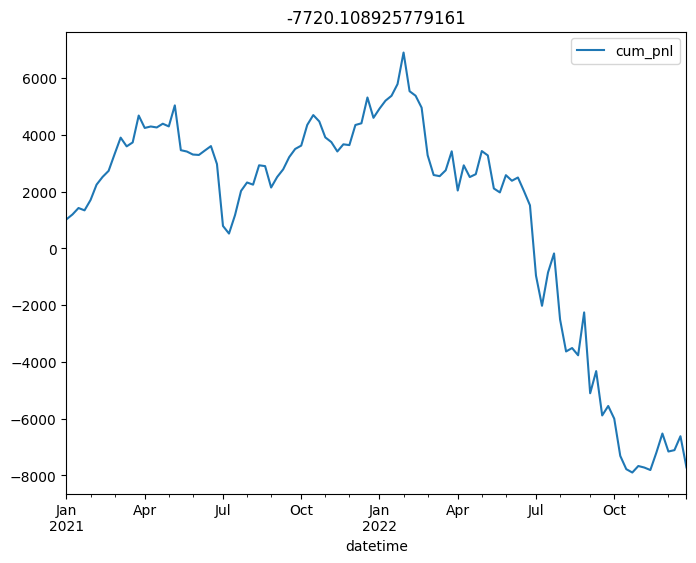

In [23]:
df_trades = pd.read_csv('./outputs/meanrevvol00.csv')
df_trades['Date'] = pd.to_datetime(df_trades['Date'])
timezone = pytz.timezone('Etc/GMT+6')
sharpes = []
for day, df_day in df_trades.groupby(pd.Grouper(key='Date', freq='D')):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()
    df_buy = df_day[df_day['Action'] == 'Buy']
    df_sell = df_day[df_day['Action'] == 'Sell']
    returns = df_sell['Price'].to_numpy() - df_buy['Price'].to_numpy()

    n_winning_trades = (returns > 0).astype(int).sum()
    n_losing_trades = len(returns) - n_winning_trades
    
    sharpe_ratio = np.mean(returns) / max(0.001, np.std(returns))
    sharpes.append({
        'datetime': day.tz_localize('US/Eastern'), 
        'n_trades': len(returns),
        'n_winning_trades': n_winning_trades,
        'n_losing_trades': n_losing_trades,
        'sharpe_ratio': sharpe_ratio,
    })

sharpes = pd.DataFrame(sharpes)
df_result = pd.merge(df_result, sharpes, how='left', on='datetime')
df_result['cum_pnl'] = df_result['pnl'].cumsum()
df_result.plot(x='datetime', y='cum_pnl', title=df_result['cum_pnl'].tolist()[-1], figsize=(8, 6))

# Check for Cointegration

In [37]:
yf.pdr_override()

# Set the stock pairs
stock_pairs = [('CL=F', 'BZ=F'), ('CL=F', 'GC=F'), ('BZ=F', 'GC=F')]

# Set the start date and the end date
start_date = '2021-01-01'
end_date = '2022-12-31'

# Download stock price data for all pairs
data = pdr.get_data_yahoo([pair[0] for pair in stock_pairs] + [pair[1] for pair in stock_pairs], start=start_date, end=end_date)['Adj Close']

# Perform the Johansen Cointegration Test for all pairs
coint_test_result = coint_johansen(data, det_order=0, k_ar_diff=1)

# Extract the eigenvalues and critical values
tracevalues = coint_test_result.lr1
critical_values = coint_test_result.cvt

# Interpret the results for each pair
for i, (stock1, stock2) in enumerate(stock_pairs):
    if (tracevalues[i] > critical_values[:, 1]).all():
        print(f"Pair {i + 1} ({stock1} and {stock2}) is cointegrated.")
    else:
        print(f"Pair {i + 1} ({stock1} and {stock2}) is not cointegrated.")

[                       0%%                      ]

[*********************100%%**********************]  3 of 3 completed


LinAlgError: SVD did not converge

In [40]:
data

Ticker,BZ=F,CL=F,GC=F
Date,,,
2021-01-04,51.090000,47.619999,1944.699951
2021-01-05,53.599998,49.930000,1952.699951
2021-01-06,54.299999,50.630001,1906.900024
2021-01-07,54.380001,50.830002,1912.300049
2021-01-08,55.990002,52.240002,1834.099976
...,...,...,...
2022-12-23,83.919998,79.559998,1795.900024
2022-12-27,84.330002,79.529999,1814.800049
2022-12-28,83.260002,78.959999,1807.900024
